###### Imports

In [1]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np

quality = 200

Populating the interactive namespace from numpy and matplotlib


$$ P(x) = \frac{1}{\sqrt{2\pi det(\Sigma)}} \exp\left\{-(x - \mu)^\top \Sigma (x - \mu)\right\} $$

# 1D

$$ L_T(\mu, \sigma^2) = \frac{\mu^2+\tilde\sigma^2}{2\sigma^2} + \sum_{t=1}^T \frac{(x_t - \mu)^2}{2\sigma^2} + \frac 1 2 \ln\sigma^2$$
$$ \frac{\partial}{\partial \mu} L_T(\mu, \sigma^2) = \frac{\mu}{\sigma^2} + \sum_{t=1}^T \frac{\mu - x_t}{\sigma^2} = 0$$
$$ \frac{\partial}{\partial \sigma^2} L_T(\mu, \sigma^2) = - \frac{\mu^2 + \tilde\sigma^2}{2\sigma^4} - \sum_{t=1}^T \frac{(x_t - \mu)^2}{2\sigma^4} + \frac{1}{2\sigma^2} = 0$$
$$ \mu^* = \frac{\sum_{t=1}^T x_t}{T + 1} $$
$$ \sigma^{*2} = \frac{1}{T+1} \left[ \tilde\sigma^2 + \sum_{t=1}^T(x_t-\mu^*)^2 \right] =\frac{1}{T+1} \left[  \tilde\sigma^2 + \sum_{t=1}^T x_t^2 -2x_t\mu^* + \mu^{*2}  \right] = \frac{1}{T+1} \left[  \tilde\sigma^2 + \sum_{t=1}^T x_t^2 - 2\mu^*\sum_{t=1}^T x_t + \mu^{*2}  \right]$$
$$ = \frac{1}{T+1} \left[  \tilde\sigma^2 + \sum_{t=1}^T x_t^2 \right] - 2\mu^{*2} +  \mu^{*2} = \frac{1}{T+1} \left[  \tilde\sigma^2 + \sum_{t=1}^T x_t^2 \right] - \mu^{*2} $$

$$L_T(\bar\mu_T, \bar\sigma_T^2) & = \frac{\bar\mu_T^2 + \tilde \sigma^2}{2\bar\sigma_T^2} + \frac 1 2 \ln(\bar\sigma_T^2) + \sum_{t=1}^T \frac{(x_t-\bar\mu_T)^2}{2\bar\sigma_T^2} + \frac 1 2 \ln(\bar\sigma_T^2)$$


###### Functions

In [2]:
def ftl_bounds(X, T, r, mu, sigma, sigma0):
    lbd, ubd = 1./4 * np.log(T + 1), 1./4 * np.log(T+1) + 1./12
    lbd_th1 = 1. / 12 * (r / sigma0) ** 4 * T ** 2 / (T + 1) + 1. / 4 * np.log(T + 1)
    ubd_th3 = 1. / 4 * ((2 * r / sigma0) ** 4 + (2 * r / sigma0) ** 2) * (T + 1) + 1. / 4 * np.log(T + 1) + 1. / 12
    for t in range(1, T+1):
        tmp = 1./(4*(t+1)) * ((X[t] - mu[t]) ** 2 / sigma[t]) ** 2
        ubd += tmp
        lbd += tmp - 1./(6*(t+1)**2) * ((X[t] - mu[t])**2/sigma[t])**3
        
    return lbd, ubd, lbd_th1, ubd_th3

def inf_l(X, T, sigma0):
    mu = 1. / (T + 1) * (X[1:T+1].sum())
    sigma = 1. / (T + 1) * (sigma0 + X[1:T+1].dot(X[1:T+1])) - mu ** 2
    
    return (T + 1) / 2 + (T + 1) / 2 * np.log(sigma)

def ftl(X, T, mu, sigma):
    if T == 0:
        return 0, sigma
    
    new_mu = mu + 1. / (T + 1) * (X[T] - mu)
    new_sigma = T / (T + 1) * sigma + T / (T + 1)**2 * (X[T] - mu)**2
    
    return new_mu, new_sigma

def regret(X_, sigma0, r, update = ftl, update_bounds = ftl_bounds):
    X = np.concatenate(([0], X_))
    mu = 0
    sigma = sigma0
    
    mu_hist = [mu]
    sigma_hist = [sigma]
    
    curr = sigma / (2 * sigma) + 1. / 2 * np.log(sigma)
    bounds = [(curr, curr, curr, curr)]
    reg_hist = [curr]
    
    for t in range(1, X.shape[0]):
        mu, sigma = update(X, t - 1, mu, sigma)
        curr += (X[t] - mu) ** 2 / (2 * sigma) + 1. / 2 * np.log(sigma)
        
        mu_hist.append(mu)
        sigma_hist.append(sigma)
        reg_hist.append(curr - inf_l(X, t, sigma0))
        bounds.append(update_bounds(X, t, r, mu_hist, sigma_hist, sigma0))
        
    return mu_hist, sigma_hist, reg_hist, np.array(bounds)
        

###### Univariate Gaussian Example

In [3]:
T = 100
r = 10

s = np.random.normal(5, 2, T)#random.rand(T) * 10
s[-1] = r - 1

m, si, r, b = regret(s, r, r)

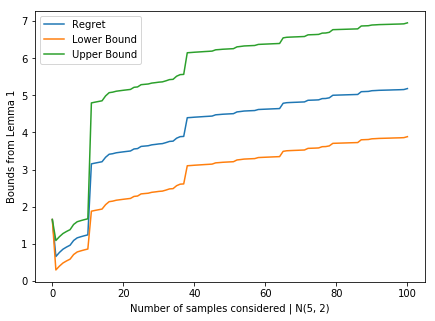

In [4]:
plt.figure(figsize=(7, 5))
plt.plot(r)
plt.plot(b[:, 0])
plt.plot(b[:, 1])
plt.legend(["Regret", "Lower Bound", "Upper Bound"])#, "Lower", "Upper", "lower_th1"])
plt.xlabel("Number of samples considered | N(5, 2)")
plt.ylabel("Bounds from Lemma 1")
plt.savefig('bounds_lemma1_gaussian.png', bbox_inches='tight', dpi=quality)


It does look logarithmic, and is between both bounds in theorem 1 and 2.

###### Special Example with linear regret up to a certain trial T

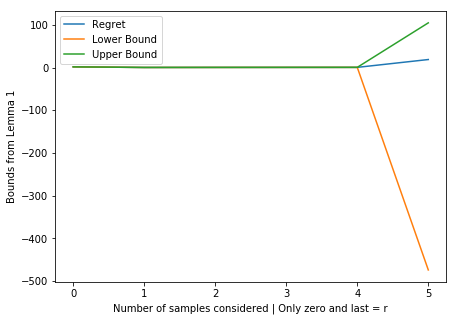

In [5]:
T = 5
r = 10

s = np.zeros(T)#random.normal(5, 2, T)#random.rand(T) * 10
s[-1] = r

m, si, r, b = regret(s, r, r)

plt.figure(figsize=(7, 5))
plt.plot(r)
plt.plot(b[:, 0])
plt.plot(b[:, 1])
plt.legend(["Regret", "Lower Bound", "Upper Bound"])#, "Lower", "Upper", "lower_th1"])
plt.xlabel("Number of samples considered | Only zero and last = r")
plt.ylabel("Bounds from Lemma 1")
plt.savefig('bounds_lemma1_zeror.png', bbox_inches='tight', dpi=quality)


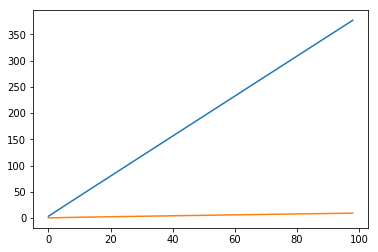

In [6]:
T = 100
r = 10

regrets_zeros = []
lbd_th1 = []
ubd_th3 = []
for t in range(1, T):
    s = np.zeros(t)
    s[-1] = r
    
    m, si, reg, b = regret(s, r, r)
    regrets_zeros.append(reg[-1])
    lbd_th1.append(b[-1][2])
    ubd_th3.append(b[-1][3])
    
plt.plot(regrets_zeros)
plt.plot(lbd_th1)

    

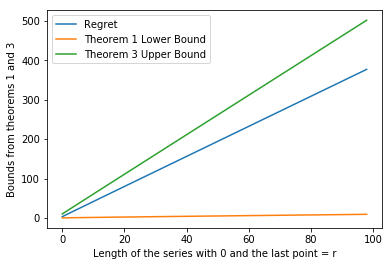

In [7]:
plt.plot(np.array(regrets_zeros))
plt.plot(np.array(lbd_th1))
plt.plot(np.array(ubd_th3))
plt.legend(["Regret", "Theorem 1 Lower Bound", "Theorem 3 Upper Bound"])
plt.title("")
plt.xlabel("Length of the series with 0 and the last point = r")
plt.ylabel("Bounds from theorems 1 and 3")

plt.savefig('bounds_series0_1d.png', bbox_inches='tight', dpi=quality)

In [8]:
gaussian_10000 = np.random.normal(5, np.sqrt(2), 1000)
r = np.max(gaussian_10000)
print(r)
gaussian_mu, gaussian_sig, gaussian_reg, gaussian_bds = regret(gaussian_10000, 15, 15)

9.477893176597615


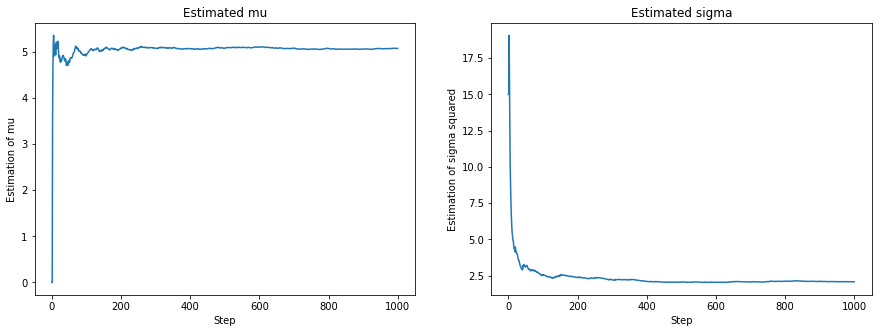

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(gaussian_mu)
plt.title("Estimated mu")
plt.xlabel("Step")
plt.ylabel("Estimation of mu")
plt.subplot(1, 2, 2)
plt.plot(gaussian_sig)
plt.title("Estimated sigma")
plt.xlabel("Step")
plt.ylabel("Estimation of sigma squared")

plt.savefig('musigma1000.png', bbox_inches='tight', dpi=quality)


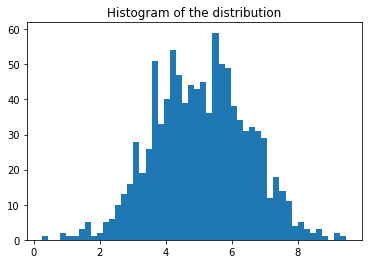

In [10]:
plt.hist(gaussian_10000, bins=50)
plt.title("Histogram of the distribution")

plt.savefig('hist1000.png', bbox_inches='tight', dpi=quality)

We do have converging estimators.

###### Multivariate functions and examples

In [11]:
import math

def ftl_bounds_m(d, T, r, mu, sigma, sigma0):
    d = X.shape[1]
    lbd_th5 = d / 12 * (r / sigma0) ** 4 * (T - d / 2 + 1. / 2) * ((T - d + 1)/(T - d + 2)) * (1 - (d - 1) / ((T - d + 1) * (T - d + 2)))**2 + d / 4 * np.log(T + 1)
    ubd_th7 = d / 4 * ((2 * r / sigma0) ** 4 + (2 * r / sigma0) ** 2) * (T + 1) + d / 4 * np.log(T + 1) + d / 12

        
    return lbd_th5, ubd_th7

def inf_l_m(X, T, sigma0):
    n = X.shape[1]
    mu = 1. / (T + 1) * (X[1:T+1].sum(axis = 0))

    
    s = np.zeros((n, n))
    for t in range(T+1):
        s += np.outer(X[t], X[t])
        
        
    sigma = 1. / (T + 1) * (sigma0 * np.eye(n) + s) - np.outer(mu, mu)
    
    return n * (T + 1) / 2 + (T + 1) / 2 * math.log(np.linalg.det(sigma))

def ftl_m(X, T, mu, sigma):
    if T == 0 or T == 1:
        return np.zeros(X.shape[1]), sigma
    
    new_mu = mu + 1. / (T + 1) * (X[T] - mu)
    new_sigma = T / (T + 1) * sigma + np.outer((X[T] - mu), (X[T] - mu)) * T / (T + 1)**2
    
    return new_mu, new_sigma

def regret_m(X_, sigma0, r, update = ftl_m, update_bounds = ftl_bounds_m):
    d = X_.shape[1]
    X = np.concatenate(([np.zeros(d)], X_))
    mu = np.zeros(d)
    sigma = sigma0 * np.eye(d)
    
    mu_hist = [mu]
    sigma_hist = [sigma]
    
    curr = 0
    for i in range(d):
        v = np.zeros(d)
        v[i] = np.sqrt(d) * sigma0
        curr += 1. / 2 * (v - mu).T.dot(np.linalg.inv(sigma)).dot(v - mu) + 1. / 2 * np.log(np.linalg.det(sigma))
        curr += 1. / 2 * (-v - mu).T.dot(np.linalg.inv(sigma)).dot(-v - mu) + 1. / 2 * np.log(np.linalg.det(sigma))
        
    curr = 1. / (2 * d) * curr
    bounds = [(curr, curr)]
    reg_hist = [curr]
    
    for t in range(1, X.shape[0]):
        mu, sigma = update(X, t - 1, mu, sigma)
        invsigma = np.linalg.inv(sigma)
        curr += 1. / 2 * (X[t] - mu).T.dot(invsigma).dot(X[t] - mu) + 1. / 2 * math.log(np.linalg.det(sigma))
        
        #(X[t] - mu) ** 2 / (2 * sigma) + 1. / 2 * np.log(sigma)
        
        mu_hist.append(mu)
        sigma_hist.append(sigma)
        reg_hist.append(curr - inf_l_m(X, t, sigma0))
        if(t > d):
            bounds.append(update_bounds(d, t, r, mu_hist, sigma_hist, sigma0))
        else:
            bounds.append(bounds[-1])
    return mu_hist, sigma_hist, reg_hist, np.array(bounds)
        

In [12]:
mean = np.array([1, 0, 0])
c = np.eye(3)
c = c.dot(c.T)
X = np.random.multivariate_normal(mean, c, size=1000)

r_d = np.max(X)
mu, cov, reg_m, bds_m = regret_m(X, r_d, r_d, ftl_m, ftl_bounds_m)

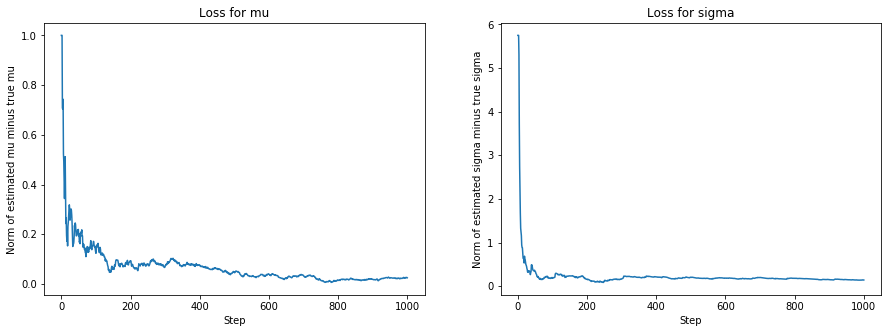

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot([np.linalg.norm(m - mean) for m in mu])
plt.title("Loss for mu")
plt.xlabel("Step")
plt.ylabel("Norm of estimated mu minus true mu")
plt.subplot(1, 2, 2)
plt.plot([np.linalg.norm(s - c) for s in cov])
plt.title("Loss for sigma")
plt.xlabel("Step")
plt.ylabel("Norm of estimated sigma minus true sigma")

plt.savefig('musigma_m10000.png', bbox_inches='tight', dpi=quality)


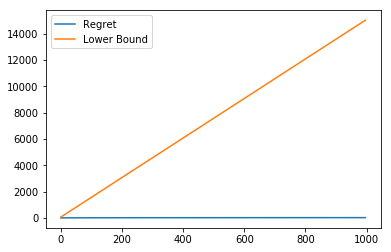

In [14]:
d = X.shape[1]
plt.plot(reg_m[d+1:])
#plt.plot(bds_m[d+1:, 0])
plt.plot(bds_m[d+1:, 1])
plt.legend(["Regret", "Lower Bound"])

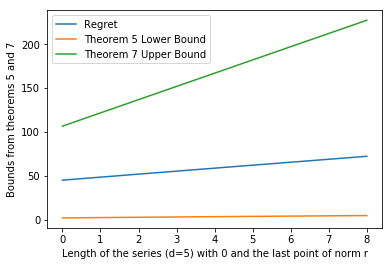

In [15]:
T = 15
r = 5
d = 5
regrets_zeros = []
lbd_th5 = []
ubd_th7 = []
for t in range(d+1, T):
    s = np.zeros((t, d))
    s[-1] = 5 * np.ones(d)
    r = np.linalg.norm(s[-1])

    
    m, si, reg, b = regret_m(s, r, r)
    regrets_zeros.append(reg[-1])
    #print(b[-1])
    lbd_th5.append(b[-1][0])
    ubd_th7.append(b[-1][1])  
    
#print(lbd_th5)
plt.plot(np.array(regrets_zeros))
plt.plot(np.array(lbd_th5))
plt.plot(np.array(ubd_th7))
plt.legend(["Regret", "Theorem 5 Lower Bound", "Theorem 7 Upper Bound"])
plt.title("")
plt.xlabel("Length of the series (d=5) with 0 and the last point of norm r")
plt.ylabel("Bounds from theorems 5 and 7")

plt.savefig('bounds_series0_dim5.png', bbox_inches='tight', dpi=quality)

In [16]:
import csv
weights = []
heights = []
sleeps = []
with open('C:/Users/User/Documents/GitHub/Online-Learning-Gaussian-Distribution/NHIS 2007 data.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        weights.append(float(row['weight']))
        heights.append(float(row['height']))
        sleeps.append(float(row['SLEEP']))
weights = np.array(weights) 
heights = np.array(heights)
sleeps = np.array(sleeps)

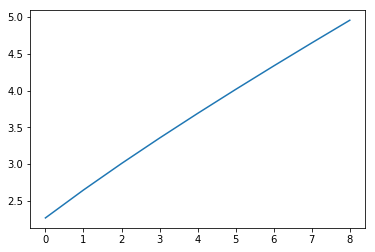

In [17]:
plt.plot(lbd_th5)

In [18]:
r_d = np.max([np.linalg.norm(x) for x in X])
mu, cov, reg_gens, bds_gens = regret_m(X, r_d, r_d, ftl_m)

In [19]:
from sklearn.preprocessing import StandardScaler

X_base = np.zeros((len(weights), 3))
X_base[:, 0] = heights + np.random.normal(0, 1, len(weights))
X_base[:, 1] = weights
X_base[:, 2] = sleeps

inds = [True if (x[0] < 90 and x[1] < 800 and x[2] < 12) else False for x in X_base]
X_base = X_base[inds]

scaler = StandardScaler()
X = scaler.fit_transform(X_base)

In [20]:
scaler.inverse_transform(mu[-1])


array([ 70.92472437, 173.20965704,   7.04242786])

In [21]:
r_unorm = np.max([np.linalg.norm(x) for x in X_base])
mu_unorm, cov_unorm, reg_gens_unorm, bds_gens_unorm = regret_m(X_base, r_unorm, r_unorm, ftl_m)

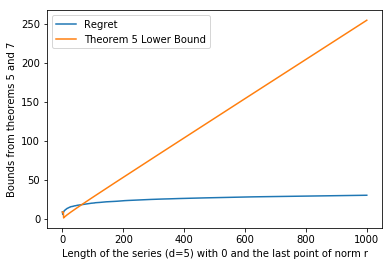

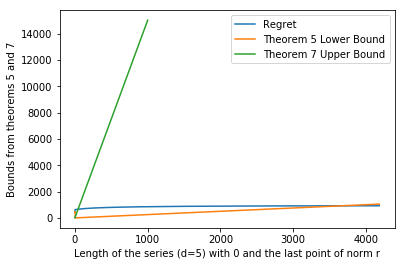

In [22]:
plt.plot(np.array(reg_gens))
plt.plot(np.array(bds_gens[:,0]))
#plt.plot(np.array(bds_gens[:,1]))
plt.legend(["Regret", "Theorem 5 Lower Bound", "Theorem 7 Upper Bound"])
plt.title("")
plt.xlabel("Length of the series (d=5) with 0 and the last point of norm r")
plt.ylabel("Bounds from theorems 5 and 7")

plt.savefig('bounds_series0_dim5.png', bbox_inches='tight', dpi=quality)
plt.show()

plt.plot(np.array(reg_gens_unorm))
plt.plot(np.array(bds_gens_unorm[:,0]))
plt.plot(np.array(bds_gens[:,1]))
plt.legend(["Regret", "Theorem 5 Lower Bound", "Theorem 7 Upper Bound"])
plt.title("")
plt.xlabel("Length of the series (d=5) with 0 and the last point of norm r")
plt.ylabel("Bounds from theorems 5 and 7")

plt.savefig('bounds_series0_dim5.png', bbox_inches='tight', dpi=quality)
plt.show()

###### Multivariate example on real data

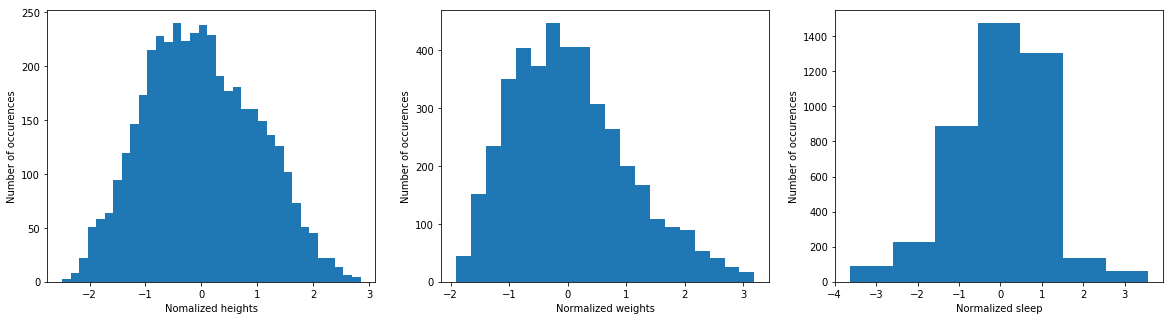

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.hist(X[:, 0], bins = 35)
plt.xlabel("Nomalized heights")
plt.ylabel("Number of occurences")
plt.subplot(1, 3, 2)
plt.hist(X[:, 1], bins = 20)
plt.xlabel("Normalized weights")
plt.ylabel("Number of occurences")

plt.subplot(1, 3, 3)
plt.hist(X[:, 2], bins = 7)
plt.xlabel("Normalized sleep")
plt.ylabel("Number of occurences")

plt.savefig('hist_whs.png', bbox_inches='tight', dpi=quality)


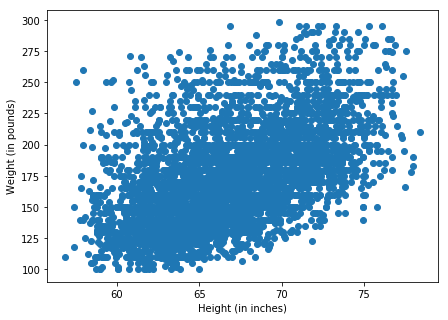

In [24]:
plt.figure(figsize=(7,5))
plt.scatter(X_base[:, 0], X_base[:, 1])
plt.xlabel("Height (in inches)")
plt.ylabel("Weight (in pounds)")


plt.savefig('weight_heights.png', bbox_inches='tight', dpi=quality)

In [25]:
X_base[:, 0] < 90
X_base[:, 1] < 800

scaler.inverse_transform(mu[-1])

array([ 70.92472437, 173.20965704,   7.04242786])

[[ 1.03715768  0.00496857  0.00528833]
 [ 0.00496857  0.90656989 -0.06324886]
 [ 0.00528833 -0.06324886  0.96903689]]


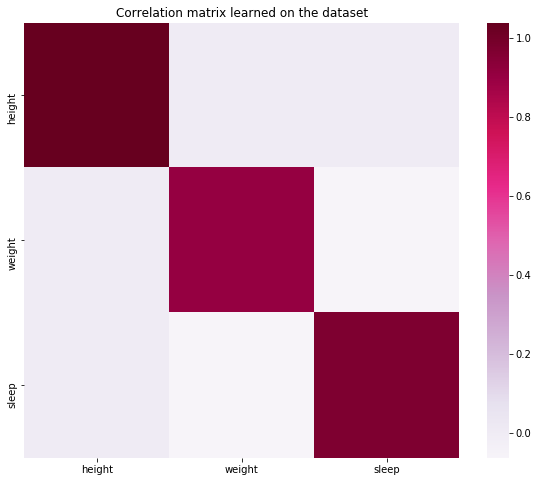

In [26]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = cov[-1]

#print(corr[i][j])
for i in range(3):
    for j in range(3):
        corr[i][j] /= (cov[-1][i][i] * cov[-1][j][j])
        
print(corr)
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),cmap='PuRd',#sns.diverging_palette(150, 10, as_cmap=True),
            square=True, ax=ax, xticklabels=["height", "weight", "sleep"], yticklabels=["height", "weight", "sleep"])
plt.title("Correlation matrix learned on the dataset")
plt.savefig('cov.png', bbox_inches='tight', dpi=quality)

In [27]:
cov[-1]

array([[ 1.03715768,  0.00496857,  0.00528833],
       [ 0.00496857,  0.90656989, -0.06324886],
       [ 0.00528833, -0.06324886,  0.96903689]])

In [28]:
X1000 = X[:200, :]
lbd_th5 = []
ubd_th7 = []
for t in range(4, 200):
    if t % 50 == 0:
        print(t)
    s = X1000[:t]
    r = np.max([np.linalg.norm(x) for x in s])

    
    m, si, reg, b = regret_m(s, r, r)
    regrets_zeros.append(reg[-1])
    #print(b[-1])
    lbd_th5.append(b[-1][0])
    ubd_th7.append(b[-1][1])  
    
#print(lbd_th5)

50
100
150


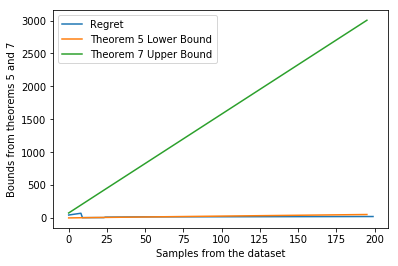

In [29]:

plt.plot(np.array(regrets_zeros[:200]))
plt.plot(np.array(lbd_th5))
plt.plot(np.array(ubd_th7))
plt.legend(["Regret", "Theorem 5 Lower Bound", "Theorem 7 Upper Bound"])
plt.title("")
plt.xlabel("Samples from the dataset")
plt.ylabel("Bounds from theorems 5 and 7")

plt.savefig('bounds_series0_dim5_realdata.png', bbox_inches='tight', dpi=quality)